In [1]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.svar_model import SVAR
import matplotlib.pyplot as plt
import pickle

target_file = "signals_bars_vols_costs.xlsx"
start_dt = "2008-01-01"

In [2]:
df = pd.read_csv(os.path.join('data', 'data_steer_jpy.csv'))
df = df.ffill().dropna()
df.set_index("date", inplace=True)
df.tail()

,USDJPY Curncy,USSW2 Curncy,JYSW2 Curncy,.USGG310 Curncy,.GJGB310 Curncy,.SPXWORLD Curncy,.NKYXASI Curncy,MXWO Index,CO1 Comdty
date,,,,,,,,,
2021-12-27,114.87,0.9403,0.00150,1.4350,-0.1523,1.4798,-149.5435,3237.70,78.60
2021-12-28,114.82,0.9387,0.00080,1.4376,-0.1580,1.4776,-150.4303,3239.28,78.67
2021-12-29,114.95,0.9468,-0.00080,1.5116,-0.1682,1.4775,-150.2749,3243.95,79.21
2021-12-30,115.08,0.9291,-0.00875,1.4779,-0.1818,1.4763,-149.7151,3237.07,79.53
2021-12-31,115.08,0.9413,-0.01050,1.4797,-0.1818,1.4748,-149.0871,3231.73,77.78


In [3]:
result = df.apply(lambda x: adfuller(x)[1])
result

USDJPY Curncy       0.383714
USSW2 Curncy        0.084944
JYSW2 Curncy        0.551558
.USGG310 Curncy     0.189847
.GJGB310 Curncy     0.342068
.SPXWORLD Curncy    0.994422
.NKYXASI Curncy     0.546726
MXWO Index          0.997028
CO1 Comdty          0.315727
dtype: float64

In [89]:
target_df = pd.DataFrame({"USDJPY Curncy": df["USDJPY Curncy"], 
                          "rates-differential": df["USSW2 Curncy"] + df["JYSW2 Curncy"],
                          "yield-curve-steepness": df[".USGG310 Curncy"] + df[".GJGB310 Curncy"],
                          "equity-mkt-relative": df[".SPXWORLD Curncy"] + df[".NKYXASI Curncy"],
#                           "equity-mkt-world": df["MXWO Index"],
                          "crude-oil": df["CO1 Comdty"]})
target_df.index = pd.to_datetime(target_df.index) 
zscore_target_df = target_df.apply(lambda x: (x - x.mean())/x.std()).resample("W-MON").last()

In [90]:
result = zscore_target_df.apply(lambda x: adfuller(x)[1])
result

USDJPY Curncy            0.313117
rates-differential       0.062334
yield-curve-steepness    0.082711
equity-mkt-relative      0.459589
crude-oil                0.106428
dtype: float64

## Fundamentals-based Equilibrium Exchange Rate

In [91]:
stfeer = sm.OLS(zscore_target_df[["USDJPY Curncy"]],
                     zscore_target_df.drop("USDJPY Curncy", axis=1))
estimate_stfeer = stfeer.fit()
print(estimate_stfeer.summary())

                                 OLS Regression Results                                
Dep. Variable:          USDJPY Curncy   R-squared (uncentered):                   0.731
Model:                            OLS   Adj. R-squared (uncentered):              0.730
Method:                 Least Squares   F-statistic:                              775.6
Date:                Sat, 08 Jan 2022   Prob (F-statistic):                   4.94e-324
Time:                        23:01:13   Log-Likelihood:                         -877.32
No. Observations:                1148   AIC:                                      1763.
Df Residuals:                    1144   BIC:                                      1783.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

In [92]:
adfuller(estimate_stfeer.resid)[1]

0.0036149562605396783

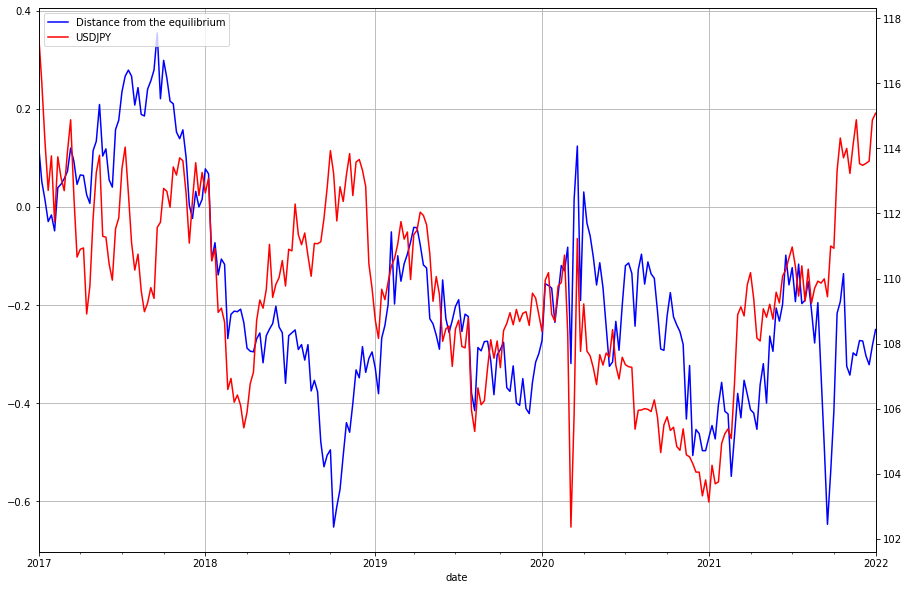

In [93]:
plt.figure(figsize=(15, 10))
ax1 = (estimate_stfeer.resid).loc["2017-01-01":].plot(color='blue', grid=True, label='Distance from the equilibrium')
ax2 = target_df["USDJPY Curncy"].loc["2017-01-01":].plot(color='red', grid=True, secondary_y=True, label='USDJPY')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc=2)

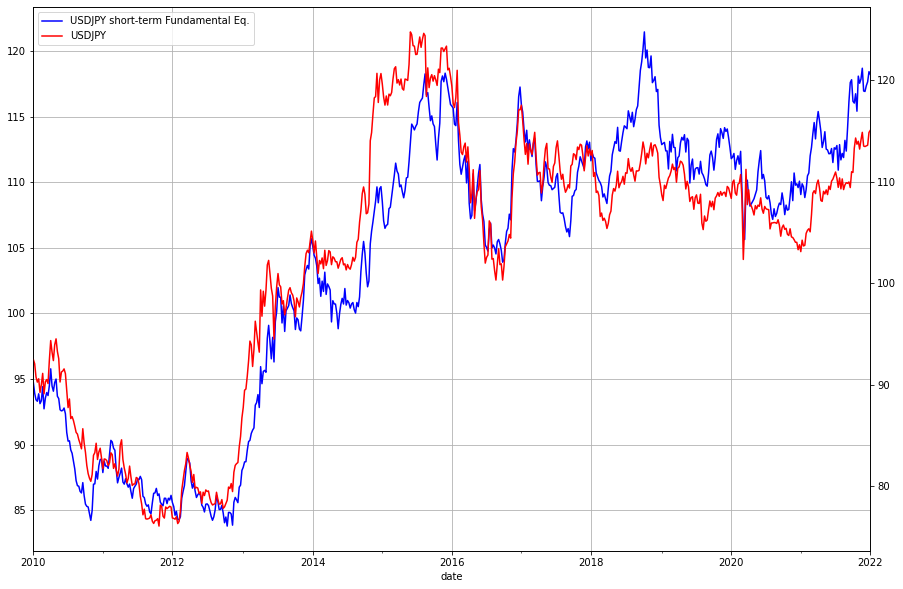

In [94]:
plt.figure(figsize=(15, 10))
ax1 = (estimate_coint_model.fittedvalues * target_df["USDJPY Curncy"].std() + target_df["USDJPY Curncy"].mean()).loc["2010-01-01":].plot(color='blue', grid=True, label='USDJPY short-term Fundamental Eq.')
ax2 = target_df["USDJPY Curncy"].loc["2010-01-01":].plot(color='red', grid=True, secondary_y=True, label='USDJPY')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc=2)

<AxesSubplot:xlabel='delta resid', ylabel='delta JPY'>

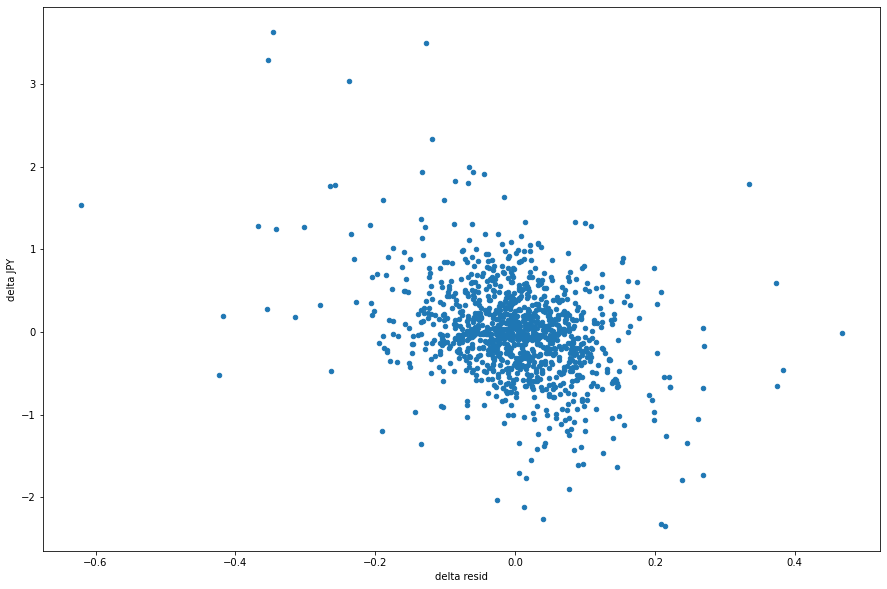

In [95]:
delta_df = pd.DataFrame({"delta JPY": target_df["USDJPY Curncy"].diff() * -1,
                         "delta resid": coint_model.fit().resid.diff()})
delta_df.plot.scatter(x='delta resid',
                      y='delta JPY',
                      figsize=(15, 10))

## Pairs-based Equilibrium Exchange Rate

In [96]:
bars_df = pd.read_excel(os.path.join("data", target_file), sheet_name="bars", engine='openpyxl',)
bars_df.index = pd.to_datetime(bars_df["date"])
bars_df.set_index("date", inplace=True)

vols_df = bars_df.pct_change().ewm(span=252/2, adjust=False).std() * np.sqrt(252)

# subset data
bars_df = bars_df.loc["2009-01-01":].resample("W-MON").last()
vols_df = vols_df.loc["2009-01-01":].resample("W-MON").last()

In [97]:
groups = {
    
    'G10': ['USDJPY', 'USDAUD', 'USDCAD', 'USDNZD', 'USDGBP', 'EURUSD', 'USDCHF'],
    
    'EM': ['USDBRL', 'USDCLP', 'USDCOP', 'USDZAR', 'USDMXN'],
}
key = list(groups.keys())[0]
g = groups[key]
instrument = 'USDJPY'

zscore_bars_df = bars_df[g].apply(lambda x: (x - x.mean())/x.std())

In [98]:
result = zscore_bars_df.apply(lambda x: adfuller(x)[1])
result

USDJPY    0.667711
USDAUD    0.469110
USDCAD    0.647954
USDNZD    0.000040
USDGBP    0.472173
EURUSD    0.353469
USDCHF    0.118989
dtype: float64

In [99]:
# svar_model = SVAR(endog=bars_df, svar_type='A')
stpeer = sm.OLS(endog=zscore_bars_df[instrument],
                        exog=zscore_bars_df.drop(instrument, axis=1))
estimate_stpeer = stpeer.fit()
print(estimate_stpeer.summary())

                                 OLS Regression Results                                
Dep. Variable:                 USDJPY   R-squared (uncentered):                   0.852
Model:                            OLS   Adj. R-squared (uncentered):              0.850
Method:                 Least Squares   F-statistic:                              635.7
Date:                Sat, 08 Jan 2022   Prob (F-statistic):                   2.55e-271
Time:                        23:02:05   Log-Likelihood:                         -310.79
No. Observations:                 670   AIC:                                      633.6
Df Residuals:                     664   BIC:                                      660.6
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [100]:
adfuller(estimate_stpeer.resid)[1]

0.00023210645116110784

In [101]:
resid = (bars_df[instrument] - (estimate_row_svar_model.fittedvalues * bars_df[instrument].std() + bars_df[instrument].mean()))
zscore_resid = (resid - resid.mean())/resid.std()

<AxesSubplot:xlabel='date'>

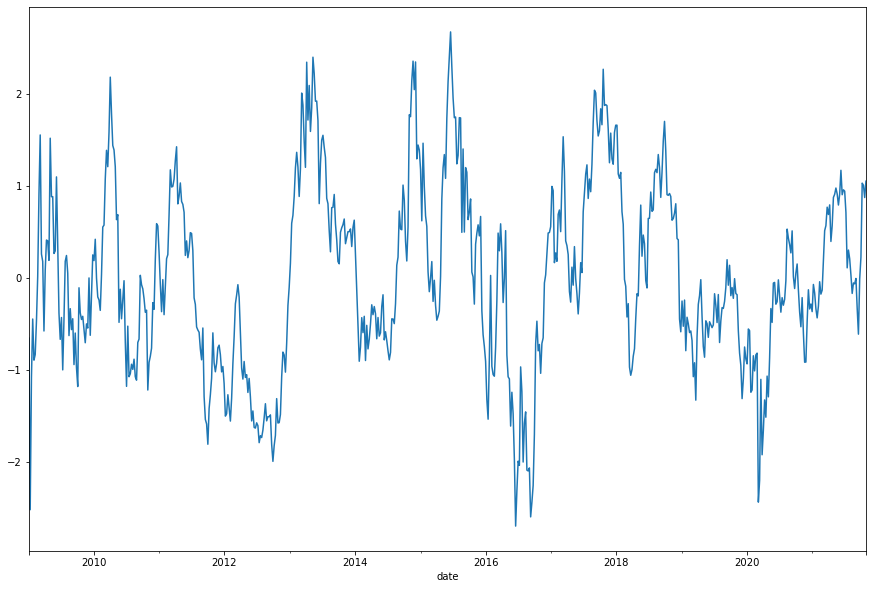

In [102]:
zscore_resid.plot(figsize=(15, 10))

In [103]:
fitted_stfeer = pd.DataFrame(estimate_stfeer.fittedvalues * bars_df[instrument].std() + bars_df[instrument].mean(),
                             columns=[instrument + ' fundamentals-based eq. exchange rate'])
fitted_stpeer = pd.DataFrame(estimate_stpeer.fittedvalues * bars_df[instrument].std() + bars_df[instrument].mean(),
                             columns=[instrument + ' pairs-based eq. exchange rate'])
instrument_bars_df = pd.DataFrame(bars_df[instrument],
                                  columns=[instrument])

plot_df = pd.concat([instrument_bars_df, fitted_stfeer, fitted_stpeer], axis=1).dropna()
plot_df['resid. stfeer'] = plot_df[instrument] - plot_df[instrument + ' fundamentals-based eq. exchange rate']
plot_df['resid. stfeer'] = (plot_df['resid. stfeer'] - plot_df['resid. stfeer'].mean())/plot_df['resid. stfeer'].std()
plot_df['resid. stpeer'] = plot_df[instrument] - plot_df[instrument + ' pairs-based eq. exchange rate']
plot_df['resid. stpeer'] = (plot_df['resid. stpeer'] - plot_df['resid. stpeer'].mean())/plot_df['resid. stpeer'].std()
plot_df['+1std'] = 1
plot_df['-1std'] = -1

<AxesSubplot:xlabel='date'>

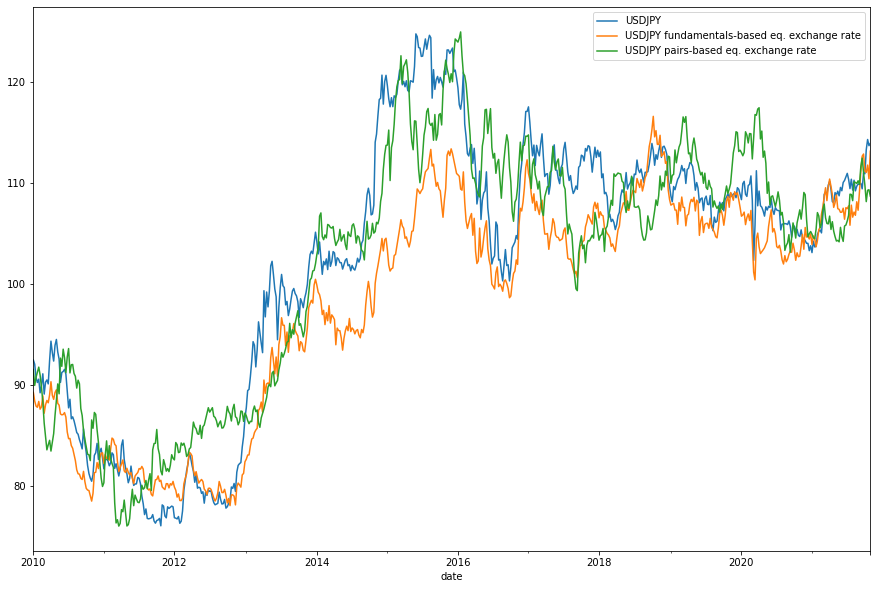

In [104]:
plot_df.drop(['resid. stfeer', 'resid. stpeer', '+1std', '-1std'], axis=1).loc["2010-01-01":].plot(figsize=(15, 10))

<AxesSubplot:xlabel='date'>

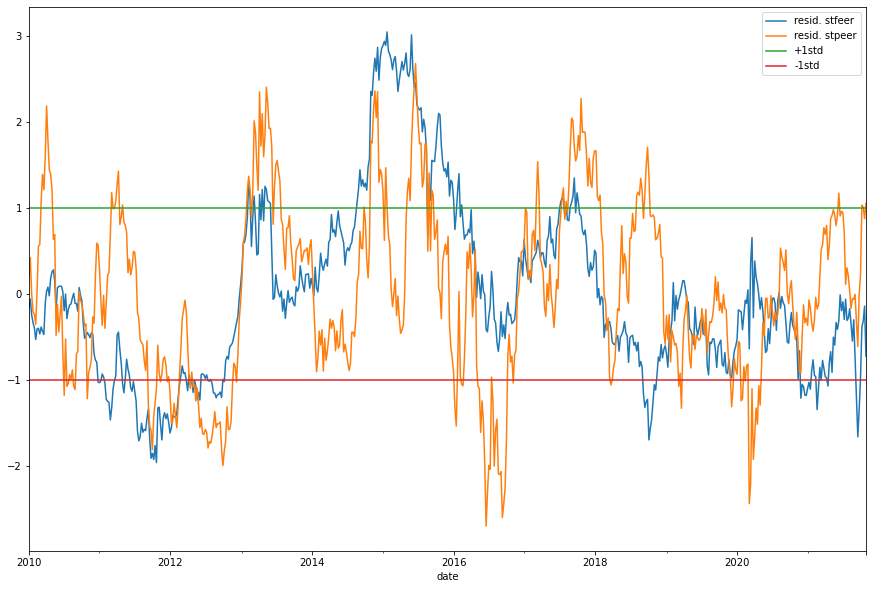

In [105]:
plot_df[['resid. stfeer', 'resid. stpeer', '+1std', '-1std']].loc["2010-01-01":].plot(figsize=(15, 10))